# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'SingleClassSVM'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/picts'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 100

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 6.29425048828e-05 seconds
Time to read data file: 7.2254319191 seconds


Using TensorFlow backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [5]:
from keras.models import load_model
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils

import multiprocessing

def NNNoveltyTrainFunction(data=None, trgt=None, inovelty=0, 
                           ifold=0, n_folds=2, n_neurons=1, 
                           trn_params=None, save_path='',
                           verbose=True, dev=False):
    
    # turn targets in sparse mode
    trgt_sparse = np_utils.to_categorical(trgt.astype(int))
    
    # load or create cross validation ids
    #n_folds = 2
    CVO = trnparams.NoveltyDetectionFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)


    n_folds = len(CVO[0])
    n_inits = trn_params.params['n_inits']

    model_prefix_str = 'RawData_%i_novelty'%(inovelty)
    analysis_path = 'NeuralNetwork'
    
    params_str = trn_params.get_params_str()
    
    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_path,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   n_neurons)
    if not dev:
        file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
        
    if verbose:
        print file_name
        
    if not os.path.exists(file_name):
        print 'Train Model'
        # training
        
        classifier = []
        trn_desc = {}
        
        train_id, test_id = CVO[inovelty][ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

        norm_data = scaler.transform(data)
        
        best_init = 0
        best_loss = 999
        
        for i_init in range(n_inits):
            print 'Neuron: %i - Fold %i of %i Folds -  Init %i of %i Inits'%(n_neurons, 
                                                                             ifold+1, 
                                                                             n_folds, 
                                                                             i_init+1,
                                                                             n_inits)
            model = Sequential()
            model.add(Dense(n_neurons, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))
            
            sgd = SGD(lr=trn_params.params['learning_rate'], 
                  decay=trn_params.params['learning_decay'], 
                  momentum=trn_params.params['momentum'], 
                  nesterov=trn_params.params['nesterov'])
            model.compile(loss='mean_squared_error', 
                          optimizer=sgd,
                          metrics=['accuracy'])
            
            # Train model
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=trn_params.params['patience'],
                                                    verbose=trn_params.params['train_verbose'], 
                                                    mode='auto')

            init_trn_desc = model.fit(norm_data[train_id], trgt_sparse[train_id], 
                                      nb_epoch=trn_params.params['n_epochs'], 
                                      batch_size=trn_params.params['batch_size'],
                                      callbacks=[earlyStopping], 
                                      verbose=trn_params.params['verbose'],
                                      validation_data=(norm_data[test_id],
                                                       trgt_sparse[test_id]),
                                      shuffle=True)
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                best_init = i_init
                best_loss = np.min(init_trn_desc.history['val_loss'])
                classifier = model
                trn_desc['epochs'] = init_trn_desc.epoch
                trn_desc['acc'] = init_trn_desc.history['acc']
                trn_desc['loss'] = init_trn_desc.history['loss']
                trn_desc['val_loss'] = init_trn_desc.history['val_loss']
                trn_desc['val_acc'] = init_trn_desc.history['val_acc']
                
        # save model
        if not dev:        
            file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
            classifier.save(file_name)
            file_name = '%s_%i_fold_trn_desc.jbl'%(model_str,ifold)
            joblib.dump([trn_desc],file_name,compress=9)
        else:
            file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
            classifier.save(file_name)
            file_name = '%s_%i_fold_trn_desc_dev.jbl'%(model_str,ifold)
            joblib.dump([trn_desc],file_name,compress=9)
    else:
        print 'Load Model'
        classifier = Sequential()
        if not dev:
            file_name = '%s_%i_fold_model.h5'%(model_str,ifold)
        else:
            file_name = '%s_%i_fold_model_dev.h5'%(model_str,ifold)
        classifier = load_model(file_name)
        
        if not dev:
            file_name = '%s_%i_fold_trn_desc.jbl'%(model_str,ifold)
        else:
            file_name = '%s_%i_fold_trn_desc_dev.jbl'%(model_str,ifold)
        [trn_desc] = joblib.load(file_name)
        
    return [classifier,trn_desc]

def NNTrainMultiCoreNeuron(ineuron):
    return NNNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                    ifold=ifold, n_folds=len(CVO[inovelty]), n_neurons=ineuron, 
                                    trn_params=trn_params, save_path=results_path, verbose=True,
                                    dev=development_flag)
def NNTrainMultiCoreFold(ifold):
    return NNNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                    ifold=ifold, n_folds=len(CVO[inovelty]), n_neurons=ineuron, 
                                    trn_params=trn_params, save_path=results_path, verbose=True,
                                    dev=development_flag)            

In [ ]:
# Train example

from Functions import TrainParameters as trnparams

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)


n_folds = 2
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    for ineuron in range(1,2,1):
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - neuron value: %i - fold %i'%(novelty_class, ineuron, ifold)
            
            trn_data = all_data[all_trgt!=novelty_class]
            trn_trgt = all_trgt[all_trgt!=novelty_class]
            
            NNNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                    ifold=ifold, n_folds=len(CVO[inovelty]), n_neurons=ineuron, 
                                    trn_params=trn_params, save_path=results_path, verbose=True,
                                    dev=True)
            
            

Novelty class: 0 - neuron: 10 - fold 0
/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/RawData_0_novelty_2_folds_1_inits_mapstd_norm_30_epochs_4_batch_size_tanh_hidden_activation_tanh_output_activation_10_neurons_0_fold_model_dev.h5
Load Model
Novelty class: 0 - neuron: 10 - fold 1
/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/RawData_0_novelty_2_folds_1_inits_mapstd_norm_30_epochs_4_batch_size_tanh_hidden_activation_tanh_output_activation_10_neurons_1_fold_model_dev.h5
Load Model
Novelty class: 1 - neuron: 10 - fold 0
/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/RawData_1_novelty_2_folds_1_inits_mapstd_norm_30_epochs_4_batch_size_tanh_hidden_activation_tanh_output_activation_10_neurons_0_fold_model_dev.h5
Load Model
Novelty class: 1 - neuron: 10 - fold 1
/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/RawData_1

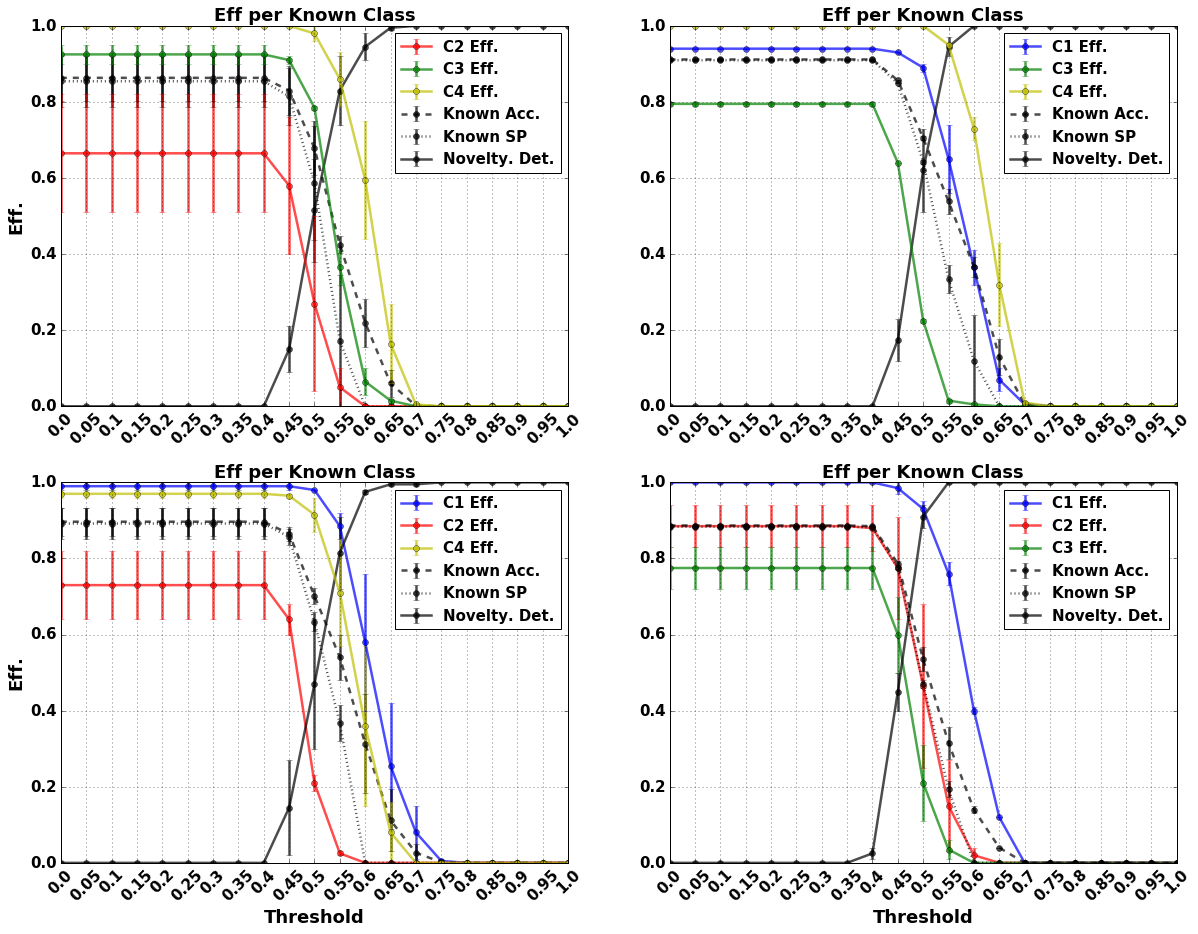

In [28]:
# analysis example - novelty detection for neural network
# thr. sweep

from sklearn import preprocessing
from Functions import TrainParameters as trnparams


# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_novelty_detection_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NNNoveltyDetectionTrnParams(n_epochs=30,n_inits=1)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NNNoveltyDetectionTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    ineuron = 10
    CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    thr_mat = np.arange(0.0,1.05,0.05)

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - neuron: %i - fold %i'%(novelty_class, ineuron, ifold)
            [classifier,trn_desc] = NNNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                                           ifold=ifold, n_folds=len(CVO[inovelty]), 
                                                           n_neurons=ineuron, 
                                                           trn_params=trn_params, 
                                                           save_path=results_path, dev=True)
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(trgt))-1])
                for iclass, class_id in enumerate(np.unique(trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novelty. Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Eff.',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=1)

In [27]:
print iclass
print inovelty

correct_class_output = np.argmax(output_of_class_events,axis=1)==2

print output_of_class_events[correct_class_output,2]>0.1

3
3
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
